<a href="https://colab.research.google.com/github/gomezan/inteligencia-artificial/blob/main/ProyectoFinalIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto final 

El objetivo del proyecto es realizar la segmentación de clientes de una tienda al por menor de regalos. Para ello se toma las ventas de la tineda entre el primero de diciembre de 2010 y el 9 de diciembre de 2011.

# Exploración de la información
Se procede a importar el dataset con la información inicial del siguiente link:   

https://www.kaggle.com/hellbuoy/online-retail-customer-clustering

Este cuenta con las siguientes características :             

*   Invoice No: Este es el número de la factura de la trasacción. 
*   Stock code: Este es el código en existencias del producto comprado.
*   Description: Esta compuesto por el producto que se esta comprando en dicho pedido.
*   Quantity: Cantidad o número de unidades compradas del producto.
*   InvoceDate: Fecha donde se realiza la transacción.
*   UnitPrice: Precio de una sola unidad del producto.
*   CustomerID: Es un indicativo único por cada uno de los clientes.
*   Country: País de origen del cliente que realiza la trasacción.



In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/retail/OnlineRetail.csv', sep=",", encoding="ISO-8859-1")
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,01-12-2010 08:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,01-12-2010 08:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,01-12-2010 08:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,01-12-2010 08:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,01-12-2010 08:34,1.69,13047.0,United Kingdom


In [ ]:
df.shape

(541909, 8)

# Preparación de la información

En esta sección se procesa la información del dataset en orden de poder realizar el agrupamiento sobre dicha información.




## Limpieza y formato de la información

En el presente se realiza el proceso de limpieza y se realizan conversiones de formato sobre la información para que esta sea más sencilla de manipular.

En primer lugar, se eliminan las muestras que tenga información o casillas faltantes. Esta es el método más sencillo y se considera aceptable dado que se tiene un dataset con suficientes muestras. 

In [ ]:
tienda = df.dropna()
tienda.shape

(406829, 8)

Las características del ID del cliente y el número de factura se convierten a strings.

In [ ]:
tienda.loc[:, ['CustomerID']] = tienda['CustomerID'].astype(str)
tienda.loc[:, ['InvoiceNo']] = tienda['InvoiceNo'].astype(str)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


Existen ciertas transacciones que manejan cantidades con valores negativos, se presumen que son devoluciones, dado que en este proyecto nos queremos concentrar en los clientes y sus ventas, estos valores son eliminados del dataset.

In [ ]:
tienda = tienda[tienda['Quantity'] >= 0]

Finalmente, los países son convertidos de un string a un número que representa la etiqueta de dicho país.

In [ ]:
tienda = tienda[tienda['Country'] != "Unspecified"]

In [ ]:
formatPais=tienda.Country.unique()
d = dict(enumerate(formatPais, 0))
countryDic = {v: k for k, v in d.items()}

In [ ]:
tienda=tienda.replace({'Country':countryDic})

El conjunto de datos despues del proceso de limpieza y formateo es igual a:  

In [ ]:
tienda.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,0
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,0


## Construcción de la información

En esta sección se obtienen las características necesarias para realizar el agrupamiento de la información. Las características deseadas se obtienen de las características del dataset de limpieza y formateo.

Las características deseadas son:

*   Recencia: Corresponde a la última vez que el cliente tuvo contacto con la tienda.
*   Frecuencia: Este es el número de veces que el cliente ha tenido contacto con la tienda.  
*   Dinero: Cantidad de dinero que ha gastado el cliente en la tienda.
*   País de origen: Este es el país donde reside el cliente en el momento de realizar la transacción.
*   Tipo de producto: Los productos se divide en tres categorías, se revisa cuál de los tres tipos es el que el cliente realiza mayor cantidad de pedidos.
*   Número de productos: Este es el número neto de productos que el cliente ha comparado. 



### Dinero

In [ ]:
tienda.loc[:, ['Total']] = tienda['Quantity']*tienda['UnitPrice']
dinero= tienda.groupby('CustomerID')['Total'].sum()
dinero = dinero.reset_index()
dinero.head()
dinero.shape

(4335, 2)

### Frecuencia

In [ ]:
frecuencia = tienda.groupby('CustomerID')['InvoiceNo'].count()
frecuencia = frecuencia.reset_index()
frecuencia.columns = ['CustomerID', 'Frecuencia']
frecuencia.head()

,CustomerID,Frecuencia
0,12346.0,1
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


### Recencia

Se modifica el formato en orden de facilitar la visualización de la fecha.

In [ ]:
tienda.loc[:, ['InvoiceDate']] = pd.to_datetime(tienda['InvoiceDate'],format='%d-%m-%Y %H:%M')

Se emplea la última fecha como la fecha de referencia dado que las fechas presentes en el dataset distan bastante en dias respecto a la fecha presente. 

In [ ]:
ultimo = max(tienda['InvoiceDate'])
print(ultimo)
tienda.loc[:, ['Diff']] = ultimo - tienda['InvoiceDate']
tienda.head()

2011-12-09 12:50:00


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,0,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,0,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,0,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,0,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,0,20.34,373 days 04:24:00


In [ ]:
recencia = tienda.groupby('CustomerID')['Diff'].min().dt.days
recencia = recencia.reset_index()
recencia.head()

,CustomerID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


### País de origen

La mayoría de los clientes solo realizan compras desde un único pais por lo que se procede a eliminar los duplicados para obtener el país en el cual reside cada cliente.

In [ ]:
pais=tienda[['CustomerID','Country']].drop_duplicates()
pais = pais.sort_values('CustomerID')

Existe un número muy bajo de clientes que realiza compras desde más de un país. Dado que este no es el comportamiento típico y dado que solo son dos países, por simplicidad se procede a eliminar un país extra de los disponibles.

In [ ]:
pais.groupby('CustomerID').size().loc[lambda x: x>1]

CustomerID
12370.0    2
12394.0    2
12417.0    2
12422.0    2
12429.0    2
12431.0    2
12455.0    2
12457.0    2
dtype: int64

In [ ]:
pais=pais.drop_duplicates(subset=['CustomerID'])
pais=pais.reset_index(drop=True)
pais.head(5)

,CustomerID,Country
0,12346.0,0
1,12347.0,15
2,12348.0,20
3,12349.0,11
4,12350.0,5


### Productos

Los productos se dividen de acuerdo a la popularidad de compra de cada uno. Existen tres categorías: 

*   Populares: Son los productos que mayores unidades vendidas se registra.
*   Medio: Productos con ventas por unidad moderadas.
*   Bajo: Son los productos que menos ventas por unidad se registran.

Dadas estas categorías se almacena el tipo de productos que más frecuentemente solicita en sus compras. 






In [ ]:
tipos = pd.DataFrame(tienda.groupby('Description')['Quantity'].sum())
tipos=tipos.sort_values('Quantity')
tipos = tipos.reset_index()
tipos.head(10)
tipos.shape

(3877, 2)

In [ ]:
bajo=tipos[tipos['Quantity'] <=100]
print(bajo.shape)
populares=tipos[tipos['Quantity'] >=1000]
print(populares.shape)
medio = tipos[~tipos.Quantity.isin(bajo.Quantity) & ~tipos.Quantity.isin(populares.Quantity)]
print(medio.shape)

(1240, 2)
(1189, 2)
(1448, 2)


In [ ]:
tienda.loc[:, ['Product_type']]=0
tienda.loc[tienda.Description.isin(medio.Description), 'Product_type'] = 1
tienda.loc[tienda.Description.isin(populares.Description), 'Product_type'] = 2
tienda.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total,Diff,Product_type
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,0,15.30,373 days 04:24:00,2
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,0,20.34,373 days 04:24:00,2
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,0,22.00,373 days 04:24:00,2
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,0,20.34,373 days 04:24:00,2
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,0,20.34,373 days 04:24:00,2
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,0,15.30,373 days 04:24:00,2
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,0,25.50,373 days 04:24:00,1
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,0,11.10,373 days 04:22:00,2
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,0,11.10,373 days 04:22:00,1
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,0,54.08,373 days 04:16:00,2


In [ ]:
tipoProducto = tienda.groupby('CustomerID')['Product_type'].mean().apply(np.round)
tipoProducto = tipoProducto.reset_index()
tipoProducto.head()

,CustomerID,Product_type
0,12346.0,2.0
1,12347.0,2.0
2,12348.0,2.0
3,12349.0,2.0
4,12350.0,1.0


### Totalidad de productos comprados


In [ ]:
producto = tienda.groupby('CustomerID')['Quantity'].sum()
producto = producto.reset_index()
producto.head()

,CustomerID,Quantity
0,12346.0,74215
1,12347.0,2458
2,12348.0,2341
3,12349.0,631
4,12350.0,197




## Fusión de la información 

En esta sección se procede a unir la información a la que se aplicará el algoritmo de agrupamiento.

In [ ]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [ ]:
datos=frecuencia
datos.loc[:,['Recencia']]=recencia.Diff
datos.loc[:,['Dinero']]=dinero.Total
datos.loc[:,['Pais']]=pais.Country
datos.loc[:,['Tipo']]=tipoProducto.Product_type
datos.loc[:,['Productos']]=producto.Quantity
datos.head()

,CustomerID,Frecuencia,Recencia,Dinero,Pais,Tipo,Productos
0,12346.0,1,325,77183.60,0,2.0,74215
1,12347.0,182,1,4310.00,15,2.0,2458
2,12348.0,31,74,1797.24,20,2.0,2341
3,12349.0,73,18,1757.55,11,2.0,631
4,12350.0,17,309,334.40,5,1.0,197


In [ ]:
attributes = ['Frecuencia','Recencia','Dinero','Pais','Tipo','Productos']
X= datos[attributes]

Se observa dado la siguiente gráfica que es necesario escalizar la información. A continuación se presenta el patrón obtenido por la información luego de emplear 3 escalizadores diferentes.

Text(0.5, 0, 'Atributos')

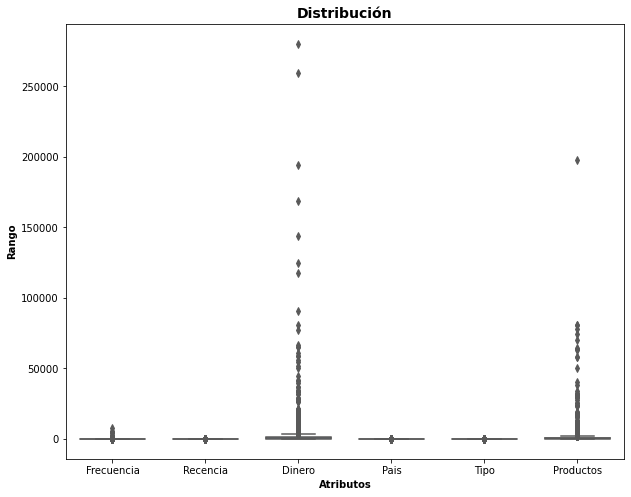

In [ ]:
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data =X, orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Distribución", fontsize = 14, fontweight = 'bold')
plt.ylabel("Rango", fontweight = 'bold')
plt.xlabel("Atributos", fontweight = 'bold')

### Escalizador Robusto

In [ ]:
robust = RobustScaler().fit(X)
xr=robust.transform(X)

varianza explicada
[0.78119672 0.12110745]


Text(0, 0.5, 'componente 2')

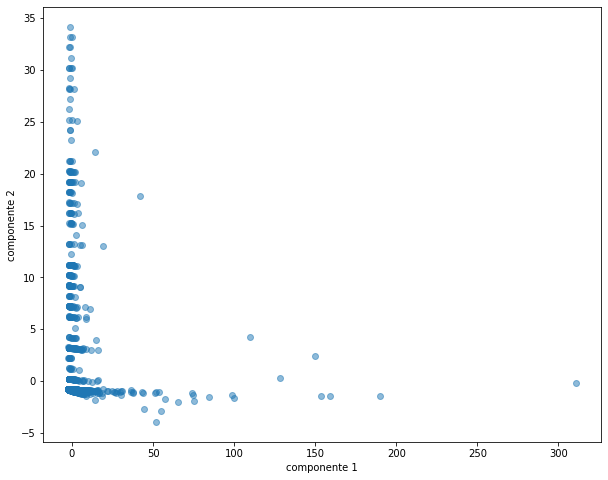

In [ ]:
visual = PCA(2)  
model = visual.fit(xr)
projected = model.transform(xr)
print("varianza explicada")
print(visual.explained_variance_ratio_)
plt.scatter(projected[:, 0], projected[:, 1],alpha=0.5)
plt.xlabel('componente 1')
plt.ylabel('componente 2')

Text(0.5, 0, 'Atributos')

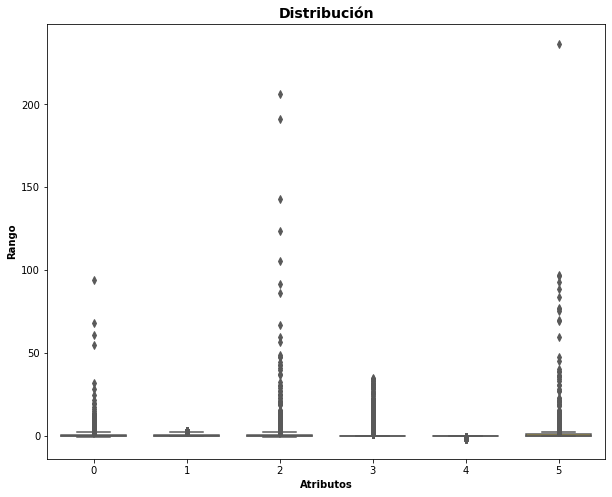

In [ ]:
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data =xr, orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Distribución", fontsize = 14, fontweight = 'bold')
plt.ylabel("Rango", fontweight = 'bold')
plt.xlabel("Atributos", fontweight = 'bold')

### Escalizador estándar

In [ ]:
standar = StandardScaler()
standar.fit(X)
xe=standar.transform(X)

varianza explicada
[0.38063521 0.19577893]


Text(0, 0.5, 'componente 2')

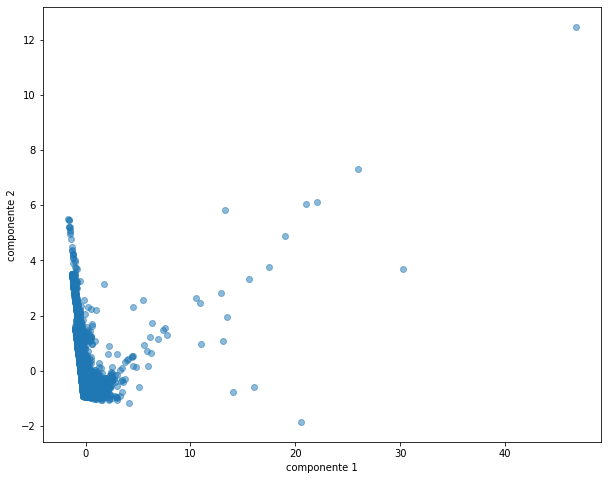

In [ ]:
visual = PCA(2)  
model = visual.fit(xe)
projected = model.transform(xe)
print("varianza explicada")
print(visual.explained_variance_ratio_)
plt.scatter(projected[:, 0], projected[:, 1],alpha=0.5)
plt.xlabel('componente 1')
plt.ylabel('componente 2')

Text(0.5, 0, 'Atributos')

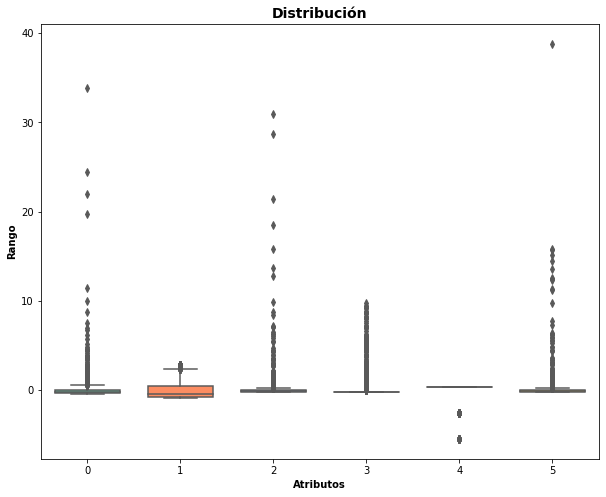

In [ ]:
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data =xe, orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Distribución", fontsize = 14, fontweight = 'bold')
plt.ylabel("Rango", fontweight = 'bold')
plt.xlabel("Atributos", fontweight = 'bold')

### Escalizador Min -Max

In [ ]:
minMax = MinMaxScaler()
minMax.fit(X)
xm=minMax.transform(X)

varianza explicada
[0.65122898 0.23891397]


Text(0, 0.5, 'componente 2')

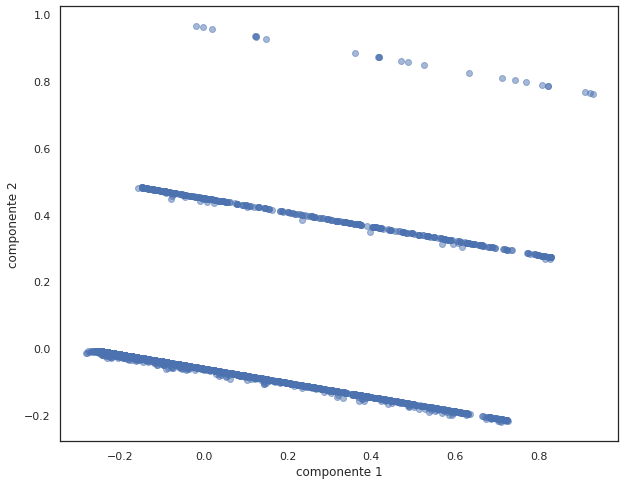

In [ ]:
visual = PCA(2)  
model = visual.fit(xm)
projected = model.transform(xm)
print("varianza explicada")
print(visual.explained_variance_ratio_)
plt.scatter(projected[:, 0], projected[:, 1],alpha=0.5)
plt.xlabel('componente 1')
plt.ylabel('componente 2')

Text(0.5, 0, 'Atributos')

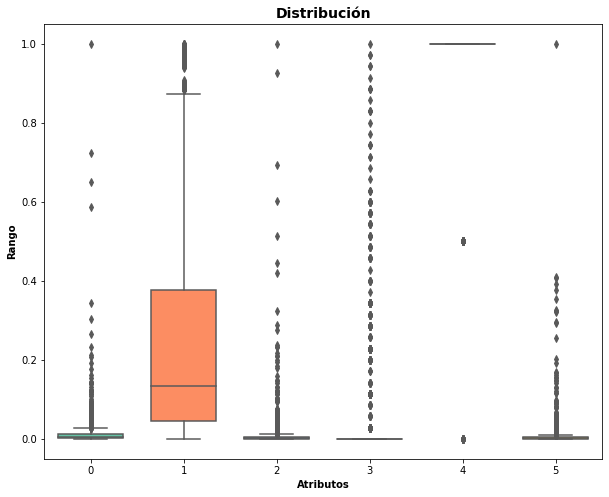

In [ ]:
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data =xm, orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Distribución", fontsize = 14, fontweight = 'bold')
plt.ylabel("Rango", fontweight = 'bold')
plt.xlabel("Atributos", fontweight = 'bold')

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

# Análisis de dimensionalidad
Además de los diferentes patrones obtenidos de la escalización, también se observa que este tiene un efecto sobre la varianza explicada de la información. Como se puede observar en la gráfica a continuación, los escalizadores Min-max y Robusto conservan mayor variabilidad en menos componentes, mientras el Estándar necesita de cerca de 4 componentes para alcanzar una variabilidad de más del 90%.   

In [ ]:
pcam = PCA(n_components=6)
pcam.fit(xm)
pcar = PCA(n_components=6)
pcar.fit(xr)
pcae = PCA(n_components=6)
pcae.fit(xe)

PCA(n_components=6)

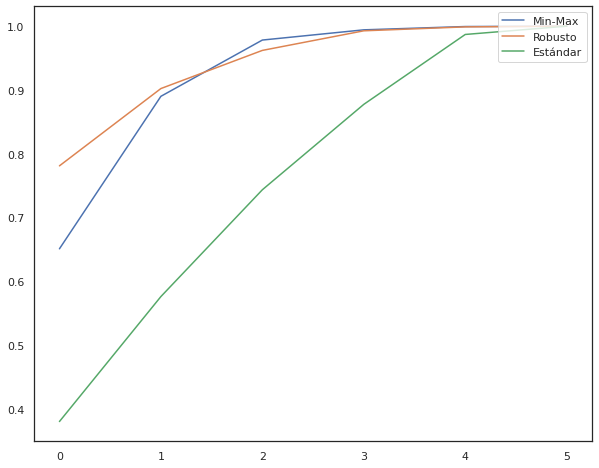

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.cumsum(pcam.explained_variance_ratio_), label = 'Min-Max')
ax.plot(np.cumsum(pcar.explained_variance_ratio_), label = 'Robusto')
ax.plot(np.cumsum(pcae.explained_variance_ratio_), label = 'Estándar')
ax.legend(loc = 'upper right')
plt.show()


Dados los diferentes patrones e impacto que se tiene sobre la variabilidad, se considera necesario probar con los diferentes escalizadores mencionados.
Se prepara información para lograr realizar pruebas sobre los escalizadores en el entrenamiento de los modelos. 

In [ ]:
pca = PCA(n_components=4)
pca.fit(xm)
x4m = pca.transform(xm)
pca.fit(xr)
x4r = pca.transform(xr)
pca.fit(xe)
x4e = pca.transform(xe)

In [ ]:
pca = PCA(n_components=3)
pca.fit(xr)
x3m = pca.transform(xm)
pca.fit(xr)
x3r = pca.transform(xr)
pca.fit(xe)
x3e = pca.transform(xe)

In [ ]:
pca = PCA(n_components=2)
pca.fit(xr)
x2m = pca.transform(xm)
pca.fit(xr)
x2r = pca.transform(xr)
pca.fit(xe)
x2e = pca.transform(xe)

# Entrenamiento

Dentro del entrenamiento fue empleado el puntaje de silueta, pero dado a que no se conseguían buenos resultados con esta, se decidió emplear otras métricas según el método utilizado.

In [ ]:
from sklearn.metrics import silhouette_score

## HDBSCAN
Con base en los resultados de la sección anterior se propone un algoritmo de densidad de muestras llamado HBDSCAN. Se instancian las dependencias y se realiza el barrido de hiperparámetros, escalizadores y componentes de PCA.

La métrica empleada para medir los clusters es el Density Based Clustering Validation o DBCV. Esta es una métrica de densidad que tiene como ventaja, en comparación a la silueta, la capacidad de tener en cuenta el ruido de la información.

In [ ]:
! pip install -U hdbscan

     |████████████████████████████████| 6.4 MB 1.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp37-cp37m-linux_x86_64.whl size=2311969 sha256=3a84f659de17870a1655a879213931a4bebd1d070814f50967640eb75bec0163
  Stored in directory: /root/.cache/pip/wheels/73/5f/2f/9a259b84003b84847c259779206acecabb25ab56f1506ee72b
Successfully built hdbscan


In [ ]:
import hdbscan

In [ ]:
min_sample = [1,3,10,30,60,99]
min_cluster = [3,10,30,100,300]
epsilon=[0.1,0.2,0.5,1]
alpha=[0.1,0.2,0.5,0.99]

tam_sample=len(min_sample)
tam_cluster=len(min_cluster)
tam_epsilon=len(epsilon)
tam_alpha=len(alpha)

res_sample=[0 for i in range (tam_sample) ]
res_cluster=[0 for j in range (tam_cluster) ]
res_epsilon=[0 for k in range (tam_epsilon) ]
res_alpha=[0 for l in range (tam_alpha)]

res_total=[]

for i in  range (tam_sample):
  for j in range (tam_cluster):
    for k in range (tam_epsilon):
      for l in range (tam_alpha):
    
        #calular score
        hc= hdbscan.HDBSCAN(gen_min_span_tree=True,min_cluster_size=min_cluster[j],min_samples=min_sample[i],cluster_selection_epsilon=epsilon[k],alpha=alpha[l])
        hc.fit(x4m)
        #Guardar resultados
        res=silueta=hc.relative_validity_
        res_sample[i]=res_sample[i]+res
        res_cluster[j]=res_cluster[j]+res
        res_epsilon[k]=res_epsilon[k]+res
        res_alpha[l]=res_alpha[l]+res
        res_total.append(res)
        #imprimir
        print("sample: ",min_sample[i]," ,cluster: ",min_cluster[j]," ,epsilon: ",epsilon[k]," ,alpha: ",alpha[l]," ,score: ",res)

array_sample = np.array(res_sample)
array_cluster = np.array(res_cluster)
array_epsilon = np.array(res_epsilon)
array_alpha = np.array(res_alpha)

array_sample=array_sample/(tam_cluster*tam_epsilon*tam_alpha)
array_cluster=array_cluster/(tam_sample*tam_epsilon*tam_alpha)
array_epsilon=array_epsilon/(tam_cluster*tam_sample*tam_alpha)
array_alpha=array_alpha/(tam_sample*tam_epsilon*tam_cluster)

print("El promedio es igual a : ")
mean=np.mean(np.array(res_total))
print(mean)

sample:  1  ,cluster:  3  ,epsilon:  0.1  ,alpha:  0.1  ,score:  0.13271278021526262
sample:  1  ,cluster:  3  ,epsilon:  0.1  ,alpha:  0.2  ,score:  0.13271278021526262
sample:  1  ,cluster:  3  ,epsilon:  0.1  ,alpha:  0.5  ,score:  0.13271278021526262
sample:  1  ,cluster:  3  ,epsilon:  0.1  ,alpha:  0.99  ,score:  0.13271278021526262
sample:  1  ,cluster:  3  ,epsilon:  0.2  ,alpha:  0.1  ,score:  0.05484802525163139
sample:  1  ,cluster:  3  ,epsilon:  0.2  ,alpha:  0.2  ,score:  0.05484802525163139
sample:  1  ,cluster:  3  ,epsilon:  0.2  ,alpha:  0.5  ,score:  0.05484802525163139
sample:  1  ,cluster:  3  ,epsilon:  0.2  ,alpha:  0.99  ,score:  0.05484802525163139
sample:  1  ,cluster:  3  ,epsilon:  0.5  ,alpha:  0.1  ,score:  0.0032969149401242837
sample:  1  ,cluster:  3  ,epsilon:  0.5  ,alpha:  0.2  ,score:  0.0032969149401242837
sample:  1  ,cluster:  3  ,epsilon:  0.5  ,alpha:  0.5  ,score:  0.0032969149401242837
sample:  1  ,cluster:  3  ,epsilon:  0.5  ,alpha:  0.99  

Después de realizar el barrido de hiperparámetros, escalizadores y componentes de PCA el mejor resultado se presenta a continuación. Este cuenta con una reducción dimensional de 4 componentes y emplea el escalizador Min-Max.    

In [ ]:
hc= hdbscan.HDBSCAN(min_cluster_size=10,min_samples=3,cluster_selection_epsilon=0.1,alpha=0.5, gen_min_span_tree=True)
hc.fit(x4m)
labelshc=hc.labels_
print("Silueta")
print(silhouette_score(x4m, labelshc, metric='euclidean'))
print("# clusters")
print(hc.labels_.max())
hc.relative_validity_

Silueta
0.5437057757886606
# clusters
2


0.21897477024999548

La conclusión del algoritmo es que existen 3 clusters, los cuales concuerdan exactamente con la imagen mostrada a continuación. Esta es la solución más obvia y fácilmente comprobable a obtener.

In [ ]:
pd.Series(hc.labels_).value_counts()

 2    3837
 1     473
 0      24
-1       1
dtype: int64

Text(0, 0.5, 'componente 2')

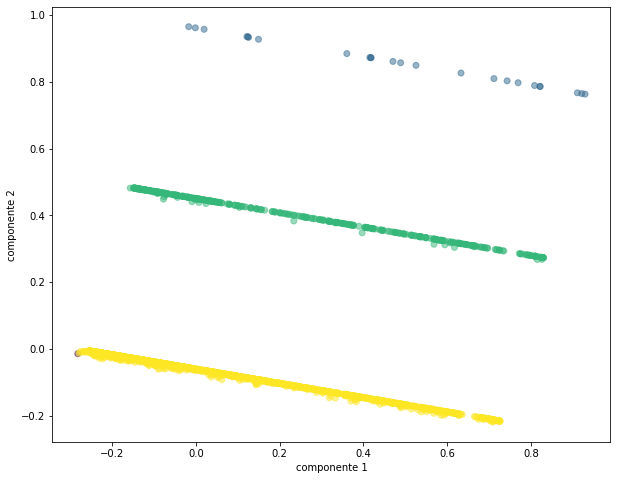

In [ ]:
plt.scatter(projected[:, 0], projected[:, 1],alpha=0.5,c=labelshc)
plt.xlabel('componente 1')
plt.ylabel('componente 2')

A continuación se presenta el árbol condensado que permite observar la jerarquía formada por el algoritmo. Dada la complejidad de las ramificaciones apenas es posible distinguir las 3 ramas que forman los 3 clusters encontrados.

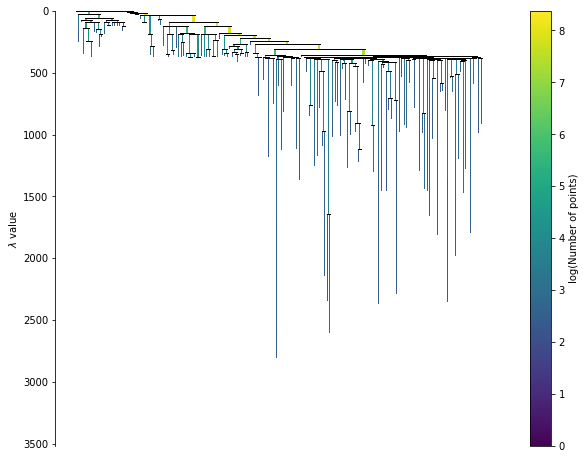

In [ ]:
hc.condensed_tree_.plot(log_size=True)

## GMM

Se propone un método paramétrico conocido como  GMM, se espera que este pueda caracterizar las funciones de probabilidad que rigen la información y así encontrar los clusters de esta.

Al igual que en HDBSCAN se procede a realizar un barrido de hiperperámetros, componentes de PCA y escalizadores.

Las métricas usadas para realizar el barrido son el Akaike information criterion o AIC y el Bayesian information criterion o BIC. Ambas métricas están íntimamente relacionadas, estas son métricas basadas en los cálculos probabilísticos derivados de GMM y son métricas de minimización. Valores bajos de estos se asocian  con menor incertidumbre y menor perdida de información. 

In [ ]:
from sklearn.mixture import GaussianMixture

In [ ]:
n_componentes = [2,5,10,20,50,100]
tipo = ['full', 'tied', 'diag', 'spherical']
random=[1,3,10,30,100]

res_totalAIC=[]
res_totalBIC=[]

#Tamaños
tam_componentes=len(n_componentes)
tam_tipo=len(tipo)
tam_random=len(random)

#almacen de respuestas
res_componentesAIC=[0 for i in range (tam_componentes) ]
res_tipoAIC=[0 for j in range (tam_tipo) ]
res_randomAIC=[0 for k in range (tam_random) ]
res_componentesBIC=[0 for i in range (tam_componentes) ]
res_tipoBIC=[0 for j in range (tam_tipo) ]
res_randomBIC=[0 for k in range (tam_random) ]


for i in  range (tam_componentes):
  for j in range (tam_tipo):
    for k in range (tam_random):
    
        #calular score
        gm = GaussianMixture(n_components=n_componentes[i], random_state=random[k], covariance_type=tipo[j]).fit(xm)
        labels=gm.predict(xm)

        #Guardar resultados
        resAIC=gm.aic(xm)
        resBIC=gm.bic(xm)
        res_totalAIC.append(resAIC)
        res_totalBIC.append(resBIC)
        res_componentesAIC[i]=res_componentesAIC[i]+resAIC
        res_tipoAIC[j]=res_tipoAIC[j]+resAIC
        res_randomAIC[k]=res_randomAIC[k]+resAIC
        res_componentesBIC[i]=res_componentesBIC[i]+resBIC
        res_tipoBIC[j]=res_tipoBIC[j]+resBIC
        res_randomBIC[k]=res_randomBIC[k]+resBIC
        #imprimir
        print("componente: ",n_componentes[i]," ,tipo: ",tipo[j]," ,random: ",random[k]," ,AIC: ",resAIC," ,BIC: ",resBIC)

array_componentesAIC = np.array(res_componentesAIC)
array_tipoAIC = np.array(res_tipoAIC)
array_randomAIC = np.array(res_randomAIC)
array_componentesBIC = np.array(res_componentesBIC)
array_tipoBIC = np.array(res_tipoBIC)
array_randomBIC = np.array(res_randomBIC)

array_componentesAIC=array_componentesAIC/(len(array_componentesAIC))
array_tipoAIC=array_tipoAIC/(len(array_tipoAIC))
array_randomAIC=array_randomAIC/(len(array_randomAIC))
array_componentesBIC=array_componentesBIC/(len(array_componentesBIC))
array_tipoBIC=array_tipoBIC/(len(array_tipoBIC))
array_randomBIC=array_randomBIC/(len(array_randomBIC))

print("El promedio es igual a : ")
mean=np.mean(np.array(res_totalAIC))
print("AIC: ")
print(mean)
mean=np.mean(np.array(res_totalBIC))
print("BIC: ")
print(mean)

componente:  2  ,tipo:  full  ,random:  1  ,AIC:  -144509.77974003396  ,BIC:  -144159.18351112716
componente:  2  ,tipo:  full  ,random:  3  ,AIC:  -116803.36201923987  ,BIC:  -116452.76579033305
componente:  2  ,tipo:  full  ,random:  10  ,AIC:  -116786.6821937187  ,BIC:  -116436.0859648119
componente:  2  ,tipo:  full  ,random:  30  ,AIC:  -116786.6821937187  ,BIC:  -116436.0859648119
componente:  2  ,tipo:  full  ,random:  100  ,AIC:  -116786.6821937187  ,BIC:  -116436.0859648119
componente:  2  ,tipo:  tied  ,random:  1  ,AIC:  -79980.42072107365  ,BIC:  -79763.68850684035
componente:  2  ,tipo:  tied  ,random:  3  ,AIC:  -76964.3607208516  ,BIC:  -76747.6285066183
componente:  2  ,tipo:  tied  ,random:  10  ,AIC:  -76963.91836448979  ,BIC:  -76747.18615025649
componente:  2  ,tipo:  tied  ,random:  30  ,AIC:  -76963.91836448979  ,BIC:  -76747.18615025649
componente:  2  ,tipo:  tied  ,random:  100  ,AIC:  -76963.91836448979  ,BIC:  -76747.18615025649
componente:  2  ,tipo:  diag  

El mejor resultado obtenido por GMM emplea el escalizador Min-Max, al igual que el mejor resultado de HBDSCAN pero este emplea las 6 componentes originales de la información. Los hiperparámetros seleccionados se muestran a continuación. Nótese que el puntaje de silueta obtenido por esta solución es increíblemente bajo, pero tanto el AIC como el BIC cuentan con valores bastante pequeños, indicando un buen modelo.

In [ ]:
gm = GaussianMixture(n_components=20, random_state=1, covariance_type='full').fit(xm)
labelsgm=gm.predict(xm)
print("Silueta")
print(silhouette_score(xm, labelsgm, metric='euclidean'))
print("AIC")
print(gm.aic(xm))
print("BIC")
print(gm.bic(xm))

Silueta
-0.16992076369613038
AIC
-210000.11767237808
BIC
-206436.7850913071


El número de clusters encontrado por GMM es de 20. Nótese que los 8 primeros clusters son los que contienen la gran mayoría de las muestras. A continuación se muestra la gráfica que contiene la representación de los clusters.

In [ ]:
print("Número de clusters")
pd.Series(labelsgm).value_counts()

Número de clusters


6     1227
2      807
15     640
19     408
1      307
13     262
12     203
5      167
11      89
10      80
3       34
0       32
16      21
18      18
14      17
9        7
7        6
4        6
17       3
8        1
dtype: int64

Text(0, 0.5, 'componente 2')

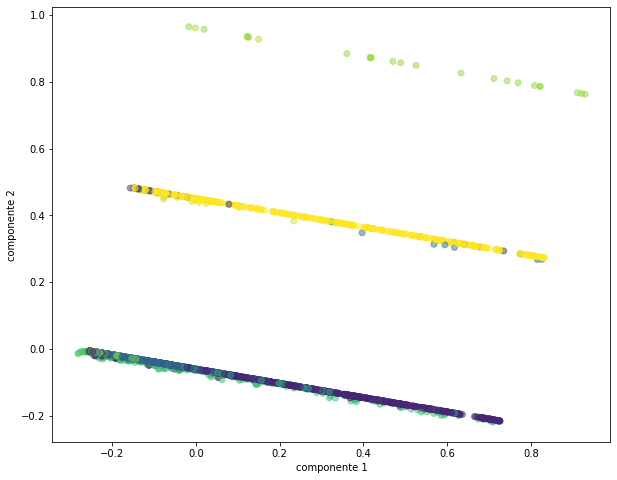

In [ ]:
model = visual.fit(xm)
projected = model.transform(xm)
plt.scatter(projected[:, 0], projected[:, 1],alpha=0.5,c=labelsgm)
plt.xlabel('componente 1')
plt.ylabel('componente 2')

Para facilitar la observación de la información, en la próxima gráfica se muestra la representación de los 4 clusters que mayor cantidad de muestras tienen. 

In [ ]:
a=labelsgm.copy()
np.putmask(a, a!=6 , -1)
b=labelsgm.copy()
np.putmask(b, b!=2 , -1)
c=labelsgm.copy()
np.putmask(c, c!=15 , -1)
d=labelsgm.copy()
np.putmask(d, d!=19 , -1)

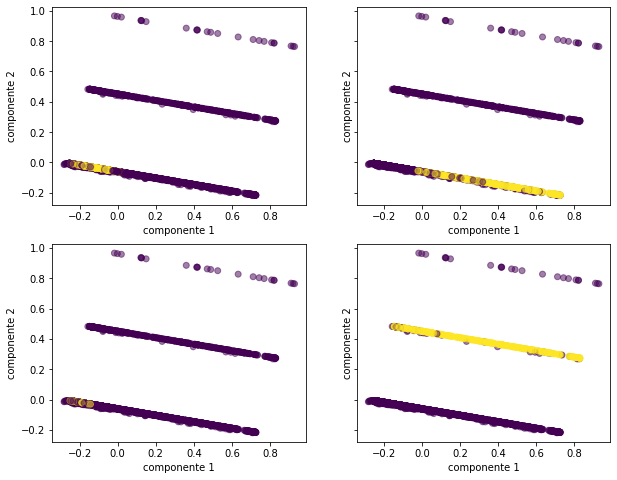

In [ ]:
fig, ax = plt.subplots(2, 2, sharey = True)
ax[0,0].scatter(projected[:, 0], projected[:, 1],alpha=0.5,c=a)
ax[0,0].set_xlabel('componente 1')
ax[0,0].set_ylabel('componente 2')

ax[0,1].scatter(projected[:, 0], projected[:, 1],alpha=0.5,c=b)
ax[0,1].set_xlabel('componente 1')
ax[0,1].set_ylabel('componente 2')

ax[1,0].scatter(projected[:, 0], projected[:, 1],alpha=0.5,c=c)
ax[1,0].set_xlabel('componente 1')
ax[1,0].set_ylabel('componente 2')

ax[1,1].scatter(projected[:, 0], projected[:, 1],alpha=0.5,c=d)
ax[1,1].set_xlabel('componente 1')
ax[1,1].set_ylabel('componente 2')

plt.show()

# Discusión y resultados

En esta sección se discuten los resultados del barridos de características sobre ambos métodos.

## Análisis de PCA

Para analizar el comportamiento de los modelos con respecto al número de componentes usado se analiza tanto el promedio obtenido por cada barrido de hiperparámetros como el mejor resultado obtenido en cada uno por cada métrica empleada. 

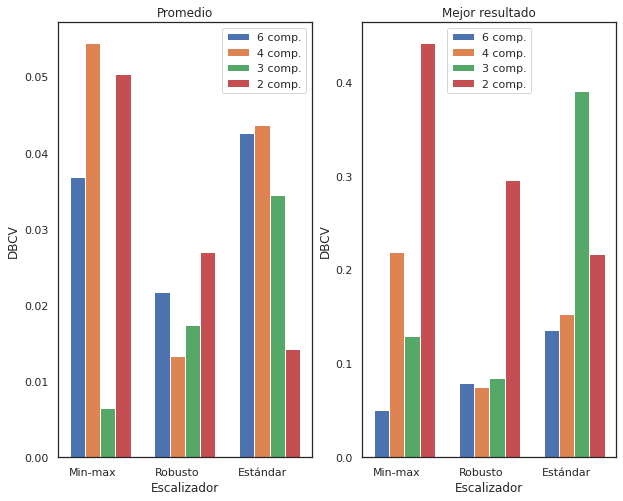

In [ ]:
PHDBSCAN6=[0.03675235739921913,0.021744609152629893,0.04259129057688213]
PHDBSCAN4=[0.054396025967151686,0.01333089885971043,0.043667906985277935]
PHDBSCAN3=[0.006461210060429141,0.01734171014386148,0.034483083856617316]
PHDBSCAN2=[0.05030777734056472,0.02700914917374678,0.01423569917915623]

RHDBSCAN6=[0.05055804307738585,0.07896476406062745,0.1360085959308536]
RHDBSCAN4=[0.218974770249996,0.07516245314094526,0.1522877478085598]
RHDBSCAN3=[0.1291696318050703,0.08418518086624774,0.39023165717098096]
RHDBSCAN2=[0.4415612235947517,0.2951206021750694,0.21684932504723042]


numero_de_grupos = len(HDBSCAN6)
indice_barras = np.arange(numero_de_grupos)
ancho_barras =0.18
 
plt.subplot(1, 2, 1)
plt.bar(indice_barras, PHDBSCAN6, width=ancho_barras, label='6 comp.')
plt.bar(indice_barras + ancho_barras, PHDBSCAN4, width=ancho_barras, label='4 comp.')
plt.bar(indice_barras + 2*ancho_barras, PHDBSCAN3, width=ancho_barras, label='3 comp.')
plt.bar(indice_barras + 3*ancho_barras, PHDBSCAN2, width=ancho_barras, label='2 comp.')
plt.legend(loc='best')
## Indicadores en el eje x
plt.xticks(indice_barras + ancho_barras, ['Min-max','Robusto', 'Estándar'])
 
plt.ylabel('DBCV')
plt.xlabel('Escalizador')
plt.title('Promedio')

plt.subplot(1, 2, 2)
plt.bar(indice_barras, RHDBSCAN6, width=ancho_barras, label='6 comp.')
plt.bar(indice_barras + ancho_barras, RHDBSCAN4, width=ancho_barras, label='4 comp.')
plt.bar(indice_barras + 2*ancho_barras, RHDBSCAN3, width=ancho_barras, label='3 comp.')
plt.bar(indice_barras + 3*ancho_barras, RHDBSCAN2, width=ancho_barras, label='2 comp.')
plt.legend(loc='best')
## Indicadores en el eje x
plt.xticks(indice_barras + ancho_barras, ['Min-max','Robusto', 'Estándar'])
 
plt.ylabel('DBCV')
plt.xlabel('Escalizador')
plt.title('Mejor resultado')
 
plt.show()

Con respecto a la imagen anterior se puede observar que no existe una respuesta única respecto al número de componentes ideal, ya que esto depende del escalizador utilizado. El escalizador robusto se beneficia de la reducción dimensional, mientras el escalizador estándar empobrece su desempeño conforme se emplean menos dimensiones. El escalizador Min-Max no parece tener efectos consistentes.

Comparando el uso de los 6 componentes originales con respecto a sus homólogos se puede concluir que estos tienen resultados más bajos, esto es interesante dado que este efecto no se aprecia cuando se emplea el promedio como referencia. 

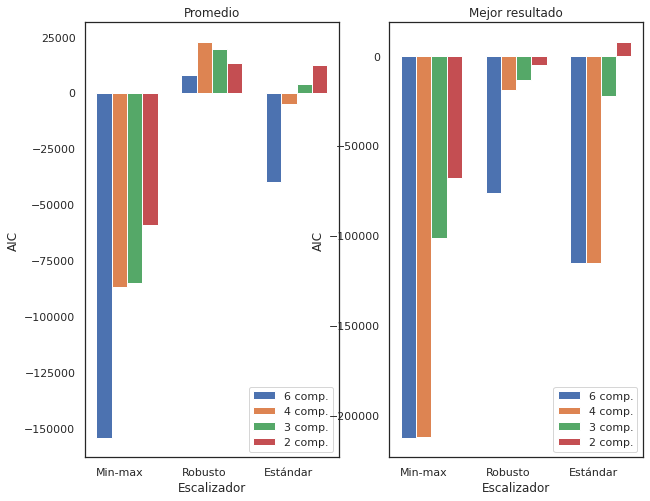

In [ ]:
PAIC6=[-154216.2627796363,8033.257882067427,-39772.730139512525]
PAIC4=[-87045.18090189114,22566.07377816242,-5174.395888426204]
PAIC3=[-84907.7629637952,19545.573986743446,3947.6664818937297]
PAIC2=[-59326.30148867184,13139.68394117537,12424.304341634863]

RAIC6=[-212473.58933081295,-76163.874203746,-115096.68268263276]
RAIC4=[-212369.17893311923,-19124.692670281394,-115096.68268263276]
RAIC3=[-101560.8873336188,-13695.51385258649,-22585.486031795554]
RAIC2=[-68203.9322260782,-5385.978559481048,7575.931911362875]

numero_de_grupos = len(HDBSCAN6)
indice_barras = np.arange(numero_de_grupos)
ancho_barras =0.18
 
plt.subplot(1, 2, 1)
plt.bar(indice_barras, PAIC6 , width=ancho_barras, label='6 comp.')
plt.bar(indice_barras + ancho_barras, PAIC4, width=ancho_barras, label='4 comp.')
plt.bar(indice_barras + 2*ancho_barras, PAIC3, width=ancho_barras, label='3 comp.')
plt.bar(indice_barras + 3*ancho_barras, PAIC2, width=ancho_barras, label='2 comp.')
plt.legend(loc='best')
## Indicadores en el eje x
plt.xticks(indice_barras + ancho_barras, ['Min-max','Robusto', 'Estándar'])
 
plt.ylabel('AIC')
plt.xlabel('Escalizador')
plt.title('Promedio')
 

plt.subplot(1, 2, 2)
plt.bar(indice_barras, RAIC6 , width=ancho_barras, label='6 comp.')
plt.bar(indice_barras + ancho_barras, RAIC4, width=ancho_barras, label='4 comp.')
plt.bar(indice_barras + 2*ancho_barras, RAIC3, width=ancho_barras, label='3 comp.')
plt.bar(indice_barras + 3*ancho_barras, RAIC2, width=ancho_barras, label='2 comp.')
plt.legend(loc='best')
## Indicadores en el eje x
plt.xticks(indice_barras + ancho_barras, ['Min-max','Robusto', 'Estándar'])
 
plt.ylabel('AIC')
plt.xlabel('Escalizador')
plt.title('Mejor resultado')

plt.show()



El comportamiento en la gráfica del AIC evidencia que los resultados son similares a los obtenidos por el DBCV, sin embargo en esta se puede observar como el Min-Max parece disminuir su desempeño conforme se reduce el número de componentes utilizado. Además en esta imagen se puede observar como los barridos de 6 componentes parecen tener mejor puntaje a sus homólogos con menor dimensiones. Este comportamiento se puede extender al BIC dada su estrecha relación con el AIC.

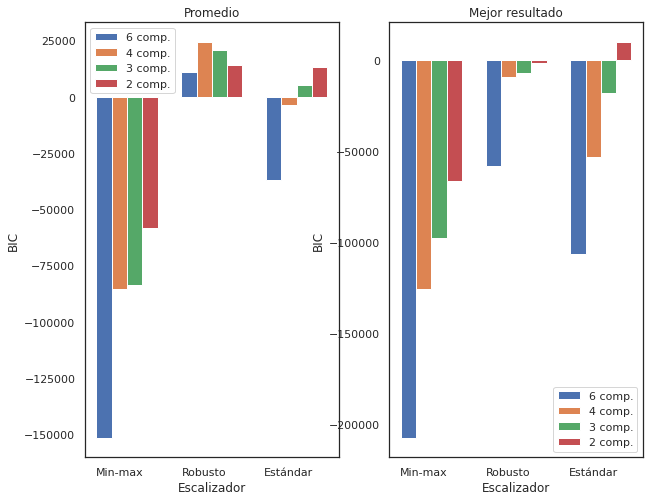

In [ ]:
PBIC6=[-151407.77450352986,10841.74615817391,-36964.24186340604]
PBIC4=[-85297.24621822775,24314.00846182582,-3426.4612047628043]
PBIC3=[-83613.2129488772,20840.12400166145,5242.216496811735 ]
PBIC2=[-58433.87472418179, 14032.11070566542,13316.731106124913]

RBIC6=[-207139.10696273786,-58321.71339083422,-106537.56384691224]
RBIC4=[-125522.77005368887,-9569.351813348645,-53360.319965064584]
RBIC3=[-97914.04901185188,-7484.948287526306,-18142.923125286947]
RBIC2=[-66300.61666813653,-1567.6669028414772,9622.509520089663]

numero_de_grupos = len(HDBSCAN6)
indice_barras = np.arange(numero_de_grupos)
ancho_barras =0.18

plt.subplot(1, 2, 1) 
plt.bar(indice_barras, PBIC6, width=ancho_barras, label='6 comp.')
plt.bar(indice_barras + ancho_barras, PBIC4, width=ancho_barras, label='4 comp.')
plt.bar(indice_barras + 2*ancho_barras, PBIC3, width=ancho_barras, label='3 comp.')
plt.bar(indice_barras + 3*ancho_barras, PBIC2, width=ancho_barras, label='2 comp.')
plt.legend(loc='best')
## Indicadores en el eje x
plt.xticks(indice_barras + ancho_barras, ['Min-max','Robusto', 'Estándar'])
 
plt.ylabel('BIC')
plt.xlabel('Escalizador')
plt.title('Promedio')

plt.subplot(1, 2, 2) 
plt.bar(indice_barras, RBIC6, width=ancho_barras, label='6 comp.')
plt.bar(indice_barras + ancho_barras, RBIC4, width=ancho_barras, label='4 comp.')
plt.bar(indice_barras + 2*ancho_barras, RBIC3, width=ancho_barras, label='3 comp.')
plt.bar(indice_barras + 3*ancho_barras, RBIC2, width=ancho_barras, label='2 comp.')
plt.legend(loc='best')
## Indicadores en el eje x
plt.xticks(indice_barras + ancho_barras, ['Min-max','Robusto', 'Estándar'])
 
plt.ylabel('BIC')
plt.xlabel('Escalizador')
plt.title('Mejor resultado')
 
plt.show()

## Barrido de hiperparámetros

A continuación se presenta el barrido únicamente de hiperparámetros teniendo en cuenta el promedio de las métricas de interés en el barrido asociado al modelo seleccionado.

### HBDSCAN

In [ ]:
def graficarHiper(x,y,paramName):
  plt.plot(x,y,"xr--",mec="b")
  plt.xlabel(paramName)
  plt.ylabel("puntaje DBCV")
  plt.show()

#### Muestras mínimas

Este valor representa  que tan conservativo es el cluster, es decir cuantas de las muestras alrededor del cluster se debe incluir y cuanto se debe rechazar. El valor óptimo de este se encuentra en 3, en valores diferentes se hallan puntaciones bajas.   

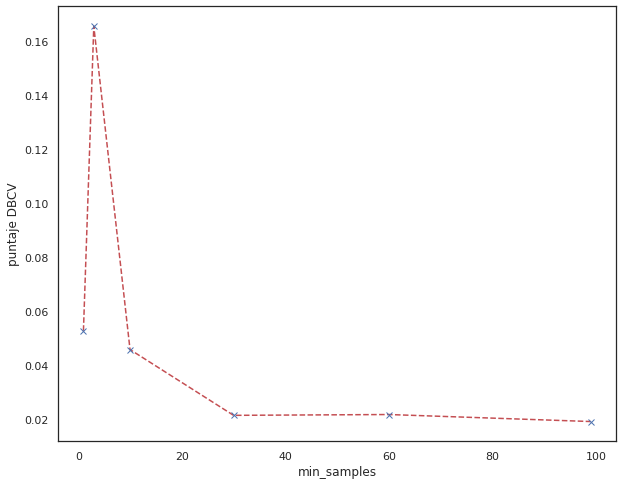

In [ ]:
graficarHiper(min_sample,array_sample,"min_samples")


#### Tamaño mínimo de cluster

Este es el número más pequeño de muestras que necesita un grupo para ser considerado un cluster. A partir de 30 este puntaje se mantiene estable en su puntaje máximo.

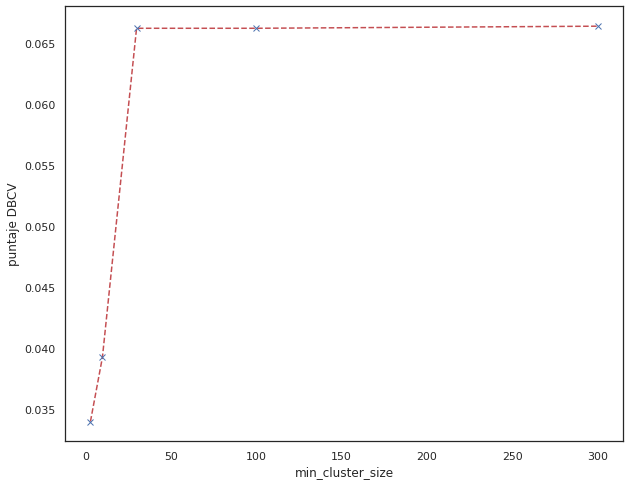

In [ ]:
graficarHiper(min_cluster,array_cluster,"min_cluster_size")


#### Epsilon

Controla la separación de los clusters dentro de la jerarquía de densidad y por ende también controla cuando los clusters deben mantenerse juntos en un solo cluster. Su puntaje óptimo se encuentra alrededor de 0.3.   

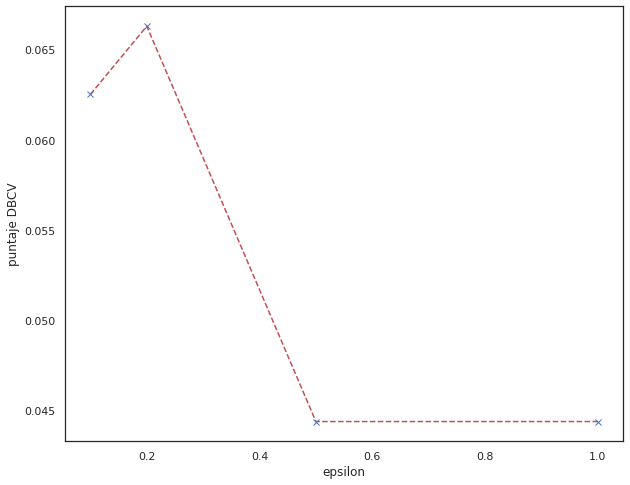

In [ ]:
graficarHiper(epsilon,array_epsilon,"epsilon")


#### Alpha

Al igual que las muestras mínimas permite determinar que tan conservativo es el cluster aunque este es un parámetro mucho más sensible, el cual no se recomienda alterar. Aún así la variación de este no parece tener ningún efecto sobre el resultado final del modelo. 

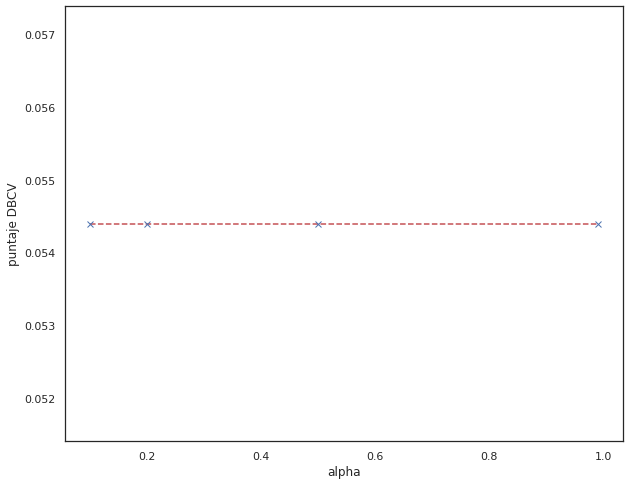

In [ ]:
graficarHiper(alpha,array_alpha,"alpha")

### GMM

In [ ]:
def graficarHiperX2(x,yAIC,yBIC,paramName):
  fig, ax = plt.subplots()
  ax.plot(x, yAIC, label = 'AIC')
  ax.plot(x, yBIC, label = 'BIC')
  ax.legend(loc = 'upper right')
  plt.show()

#### Número de componentes

El número de componentes es igual al número de clusters a formar. Entre mayor era este hipeparámetro mejor eran los resultados, aún así mayor número de clusters hacen la información más difícil de interpretar.


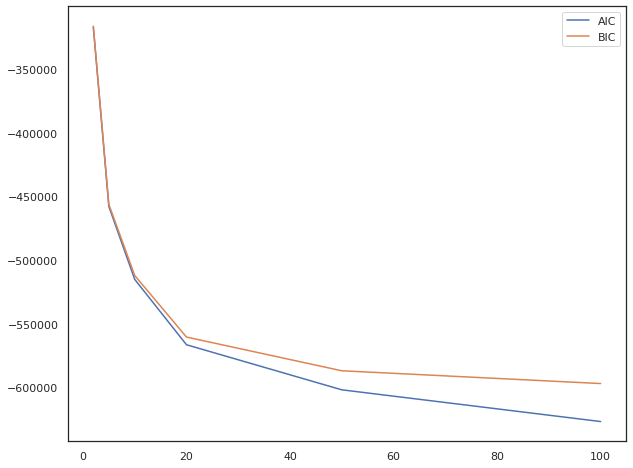

In [ ]:
graficarHiperX2(n_componentes,array_componentesAIC,array_componentesBIC,"n_components")

#### Tipo de la covarianza

El tipo de covarianza se distingue en cuatro categorías:

*   full: Cada componente tiene su propia matriz de covarianza.
*   tied: Los componentes comparten la misma matriz de covarianza.
*   diag: Cada componente tiene su propia diagonal de covarianza. 
*   spherical: Cada componente tiene su propia varianza.

Las covarianzas que mejor se desempeñaron fue en primer lugar full, seguido por tied. Las restantes tuvieron desempeño  mucho inferior a las previamente mencionadas.


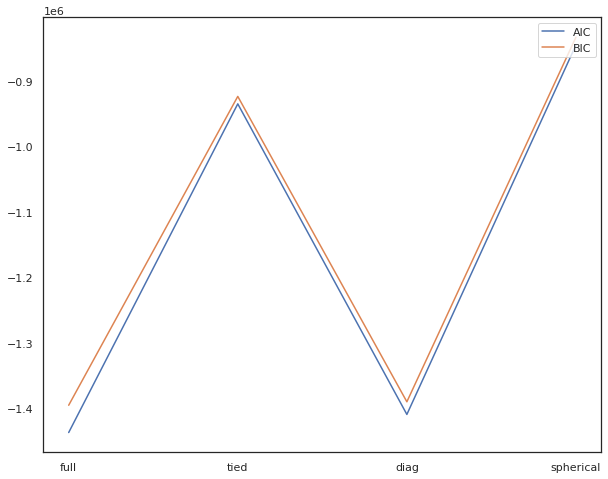

In [ ]:
graficarHiperX2(tipo,array_tipoAIC,array_tipoBIC,"covariance_type")

#### Semilla aleatoria

La semilla aleatoria también se tomó como un hiperparámetro dentro del modelo. Los mejores puntajes se asocian con un valor cercano a 0. Es sorpresivo observar como este hiperparámetro podía ser decisivo en los puntajes obtenidos por el algoritmo.

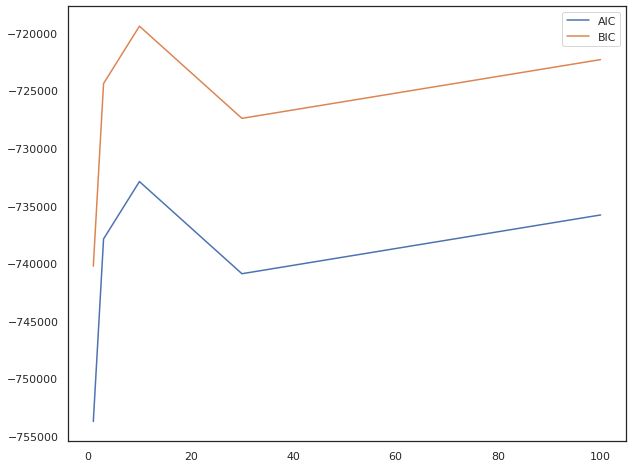

In [ ]:
graficarHiperX2(random,array_randomAIC,array_randomBIC,"random_state")

# Conclusiones

Comparando ambos métodos implementados se pueden apreciar las fortalezas y debilidades de cada uno. El método HBDSCAN es un método jerárquico basado en densidades, mientras GMM es un método plano basado en probabilidad. HBDSCAN resulta ser más intuitivo lo que resulta útil para definir o modificar parámetros, mientras que GMM no es tan intuitivo al estar basado en funciones de probabilidad, esta característica resulta ser la más importante de acuerdo a los resultados obtenidos. HBDSCAN obtuvo el resultado más obvio, aunque no deja de ser correcto, este resultado es posible obtenerlo a simple vista. En cambio, GMM fue capaz de tomar los grupos básicos y subdividirlos en 20 grupos totales de los que es posible resaltar 8 por su tamaño. Este se encuentra más cercano al resultado que se esperaba del proyecto, de forma que la capacidad de GMM de aplicar funciones de probabilidad sobre el conjunto de datos la hace una técnica más capaz dentro de este problema al no solo entender la forma del cluster, sino al caracterizar el mecanismo detrás de este. En cuanto a las debilidades de GMM se encuentra su necesidad de asignar un gran número de custers, con frecuencia se observaba un número de 20, 50 y hasta 100 clusters, donde dentro de la mayoría se encontraban un número inferior a 10 elementos. En contraste HDBSCAN solía arrojar respuestas con un número de entre 3 y 10 clusters. 

En cuento al uso de las métricas, el uso de BIC y AIC tuvo mejores resultados que el DBCV. En primer lugar, tener dos métricas otorga dos marcos de referencia además que las puntuaciones de estas eran más consistentes con agrupamiento de clusters de mejor calidad, mientras que en el DBCV muchas veces se necesitaba apoyarse de la gráfica para poder determinar el acabado del cluster lo cual conlleva a una perdida de objetividad sobre la elección del modelo. Aunque otra posible causa de esto es que HDBSCAN podía ser verificado observando los patrones de las gráficas, mientras que GMM no contaba con esa posibilidad. 

En resumidas cuentas no se considera que GMM sea una técnica superior a HDBSCAN, solo que esta se adapta más a la información y dominio del problema. HBDSCAN puede ser más útil en datasets donde exista mucha información y el ruido presente sea mucho mayor. Observando las gráficas derivadas del escalizador Min-Max, que fue el que obtuvo mejor rendimiento, se puede observar como apenas se encuentra ruido o perturbaciones sobre este.

En cuanto al fenómeno encontrado, donde el escalizador determina tanto el patrón de la información, como la varianza de cada componente y el desempeño del modelo final, este fenómeno era desconocido y demuestra que este factor tiene mucho más peso del que se creía inicialmente.  


Text(0, 0.5, 'componente 2')

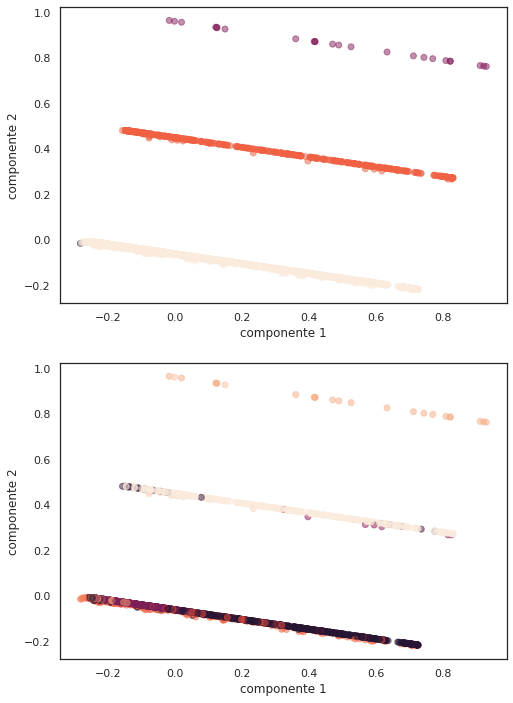

In [ ]:
fig, ax = plt.subplots(2, sharey = True, figsize=(8, 12))
ax[0].scatter(projected[:, 0], projected[:, 1],alpha=0.5,c=labelshc)
ax[0].set_xlabel('componente 1')
ax[0].set_ylabel('componente 2')

ax[1].scatter(projected[:, 0], projected[:, 1],alpha=0.5,c=labelsgm)
ax[1].set_xlabel('componente 1')
ax[1].set_ylabel('componente 2')